In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [2]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
experiment_dir = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_pilot_analysis/visual_behavior_pilot_manuscript_initial_submission/'
model_dir = '/allen/programs/braintv/workgroups/cortexmodels/brianh/exps/stsp_final/noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/'

In [4]:
manifest = pd.read_csv(os.path.join(experiment_dir,'visual_behavior_data_manifest.csv'))

In [5]:
selected_data = manifest[(manifest.cre_line=='Slc17a7-IRES2-Cre')&  # Vip-IRES-Cre
                         (manifest.session_type=='behavior_session_A')] #&  # behavior_session_B, C, D
#                          (manifest.targeted_structure=='VISp')]  # VISp
selected_data

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
8,639253368,639001089,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,334310,599659785,9/28/2017 14:14
12,661423848,661409179,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355469,643316601,2/6/2018 15:03
16,670396087,670266085,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355471,644831080,3/6/2018 13:37
28,692342909,692315205,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,369320,656813113,4/30/2018 16:09
40,729951441,729705760,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,382897,679238912,8/3/2018 10:11
44,715228642,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,6/27/2018 13:08
48,720001924,719860866,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,7/13/2018 14:33
52,719321260,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,685152008,7/12/2018 10:27
64,754566180,754511300,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,401625,717693518,9/17/2018 15:13
84,768224465,768053094,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,407486,739783701,10/24/2018 14:21


In [6]:
experiment_id = selected_data.experiment_id.values
experiment_id

array([639253368, 661423848, 670396087, 692342909, 729951441, 715228642,
       720001924, 719321260, 754566180, 768224465, 760696146, 774379465,
       673139359])

In [7]:
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

In [8]:
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.svm import LinearSVC, SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Linear SVM vs non-linear RBF SVC
model = LinearSVC(C=1.0,max_iter=1e4)
model_nl = SVC(C=1.0,max_iter=1e4,gamma='scale')

nCrossVal = 3

In [9]:
# feature pre-processing included here
clf = make_pipeline(StandardScaler(), model)

# Decoding analysis

In [113]:
# Loop over all experiments
results = {}

# num_neurons = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_neurons = [110, 120, 130, 140, 150]
num_bootstraps = 10

# for determining catch trial predictions
cv = StratifiedKFold(n_splits=3)

for e in experiment_id:
    dataset= VisualBehaviorOphysDataset(e, cache_dir=experiment_dir)
    analysis = ResponseAnalysis(dataset, use_events=False)  # dff or events?
    
    # Organize results dict by experiment id
    results[str(e)] = {}
    
    # get trials and flash dataframe
    tdf = analysis.trial_response_df
    fdf = analysis.flash_response_df
    
    # merge on change time
    fdf['change_time'] = fdf.start_time.values
    fdf = pd.merge(fdf, dataset.all_trials[['change_time', 'initial_image_name', 'change_image_name', 'trial_type', 'response', 'response_type']],
                                 on='change_time', how='left')
    
    # map image name to categorical variable
    fdf['image_index'] = fdf['image_name'].astype('category').cat.codes
    
    # find number of cells and number of flashes
    num_cells = len(fdf.cell_specimen_id.unique())
    results[str(e)]['num_neurons'] = num_cells  # save number of cells
    num_flashes = len(fdf.flash_number.unique())
    
    # extract image change times
    change_times = fdf[fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]].change_time.values
    
    # extract responses (cells x num flashes)
    traces = fdf.mean_response.values.reshape(-1, num_cells)
    print(traces.shape)
    
    # loop through num_neurons
    for nn in num_neurons:
        # only do this if there are enough cells
        if num_cells > nn:
            results[str(e)][nn] = {}
            results[str(e)][nn]['image'] = []
            results[str(e)][nn]['change'] = []

            # loop through num_bootstraps
            for nb in range(num_bootstraps):
                # choose a random subset of neurons
                idx = np.random.choice(num_cells, nn, replace=False)

                # decode image identity
                img_idx = fdf[(fdf.engaged==True)&(fdf.image_name!='omitted')].flash_number.unique()
                X = traces[img_idx, :][:, idx]
                y = fdf.loc[(fdf.flash_number.isin(img_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'image_index']
                cv_image = cross_validate(model,X,y,cv=nCrossVal,return_estimator=True)  # can also pass pipeline here
                results[str(e)][nn]['image'].append(cv_image['test_score'].mean())

                # decode image change
                change_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='go')].flash_number.unique()
                X_change = traces[change_idx, :][:, idx]
                y_change = np.ones(len(change_idx))
                 # use the pre-change stimulus here
                X_prechange = traces[change_idx-1, :][:, idx]
                y_prechange = np.zeros(len(change_idx))
                X = np.concatenate((X_change, X_prechange))
                y = np.concatenate((y_change, y_prechange))
                cv_change = cross_validate(model,X,y,cv=nCrossVal,return_estimator=True)  # can also pass pipeline here
                results[str(e)][nn]['change'].append(cv_change['test_score'].mean())

        #         # correlate behavior and decoder
        #         # find catch trials
        #         catch_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='catch')].flash_number.unique()    
        #         X_catch = traces[catch_idx, :]
        #         y_catch = np.zeros(len(catch_idx))

        #         # actual behavior
        #         go_true = fdf.loc[(fdf.flash_number.isin(change_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'response'].values
        #         catch_true = fdf.loc[(fdf.flash_number.isin(catch_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'response'].values

        #         # model go trial predictions
        #         go_preds = cross_val_predict(model, X, y, cv=nCrossVal)[y==1]
        #         catch_preds = []
        #         for i, (_, test_index) in enumerate(cv.split(X_catch, y_catch), 1):
        #             catch_preds.append(cv_change['estimator'][-i].predict(X_catch[test_index]))
        #         catch_preds = np.concatenate(catch_preds)

        #         # store behavior and predictions for correlation analysis
        #         results[str(e)]['y_true'] = np.concatenate((go_true, catch_true))
        #         results[str(e)]['y_pred'] = np.concatenate((go_preds, catch_preds))

loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 62)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 128)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4787, 163)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 105)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 285)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 186)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 162)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 57)
loading trial response dataframe
loading flash res

In [49]:
# total number of neurons (min/max, mean/std)
print(np.array([results[r]['num_neurons'] for r in results]).min(), np.array([results[r]['num_neurons'] for r in results]).max())
print(np.array([results[r]['num_neurons'] for r in results]).mean(), np.array([results[r]['num_neurons'] for r in results]).std())

(57, 310)
(157.3846153846154, 76.62349354678113)


In [103]:
df_total = pd.DataFrame(columns=['ophys_experiment_id', 'num_neurons', 'decoding_type', 'mean_accuracy'])

In [114]:
for ecid, val1 in results.items():
    for nn, val2 in val1.items():
        # filter out string key
        if isinstance(nn, int):
            df_total = df_total.append(pd.DataFrame({'ophys_experiment_id': int(ecid), 'num_neurons': nn, 'decoding_type': 'change', 'mean_accuracy': val2['change']}))
            df_total = df_total.append(pd.DataFrame({'ophys_experiment_id': int(ecid), 'num_neurons': nn, 'decoding_type': 'image', 'mean_accuracy': val2['image']}))

In [116]:
df_total.to_csv('decoding_num_neurons_50.csv', index=False)

---

In [129]:
sns.set_context({'axes.spines.right': False, 'axes.spines.top': False})

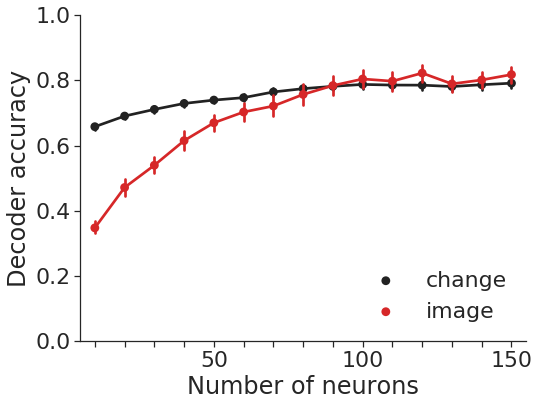

In [138]:
plt.figure(figsize=(8,6))

ax = sns.pointplot(x="num_neurons", y="mean_accuracy", kind="point", hue="decoding_type", color=colors[0], data=df_total)
ax.set(ylim=(0, 1.0))
ax.set_xlabel('Number of neurons')
ax.set_ylabel('Decoder accuracy')
ax.set_xticklabels(['']*4+[50]+['']*4+[100]+['']*4+[150])
ax.legend(frameon=False, loc='lower right')

plt.savefig('decoding_num_neurons.png', dpi=300, bbox_inches='tight')